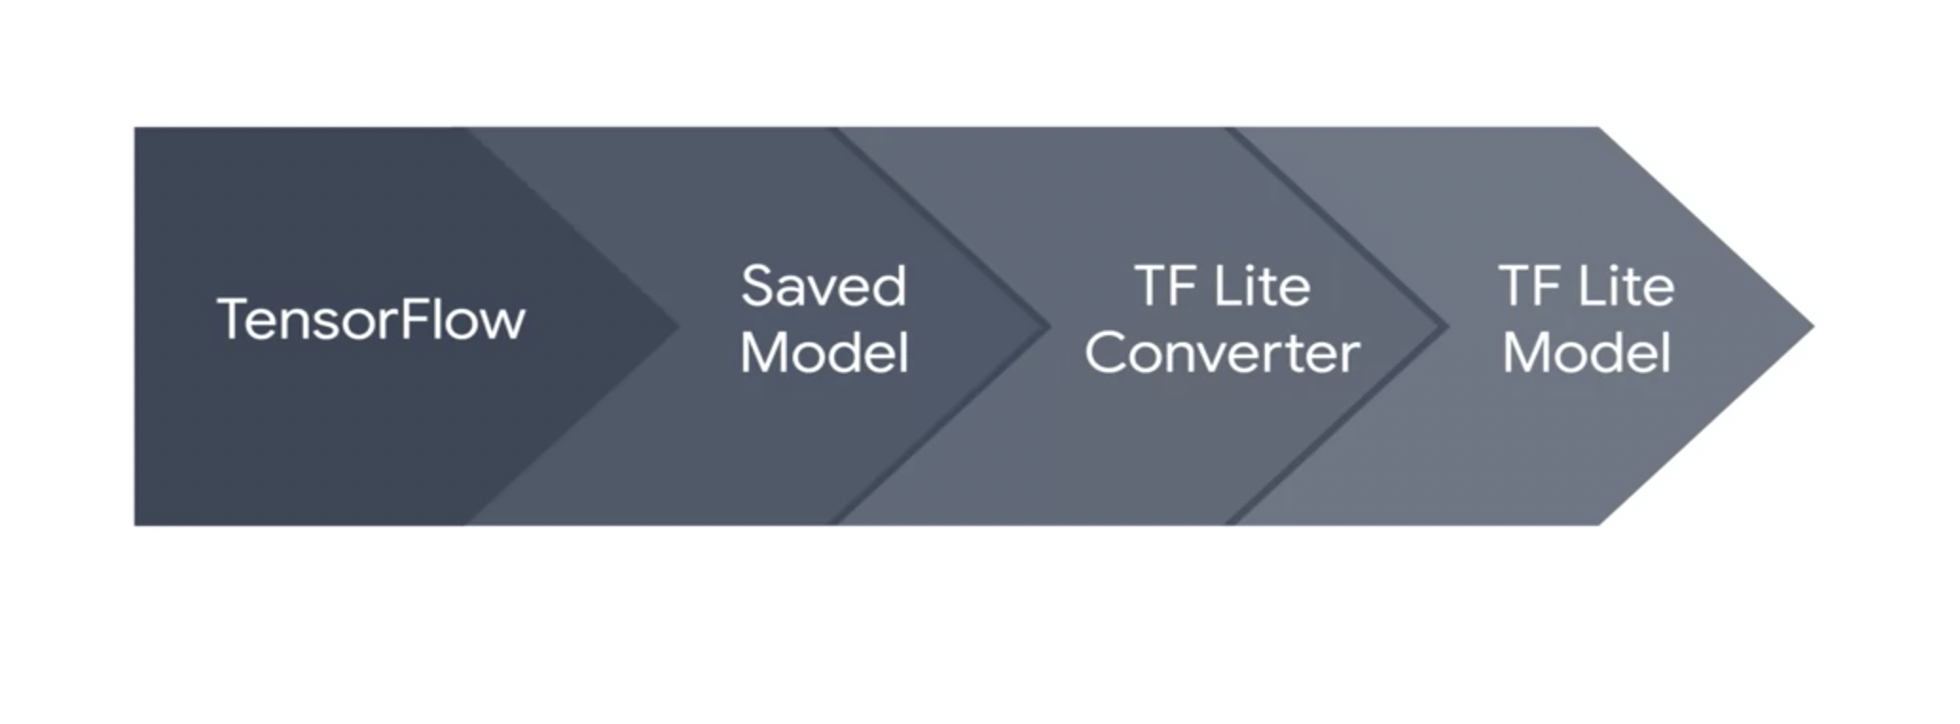

## Sanity Checks

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# TensorFlow import
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
# Which GPU?
!nvidia-smi

Sat Jul  3 12:48:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    32W /  70W |   8922MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Step1 : Build an Tensorflow Model 

*   Problem Statement - Flower classification dataset.
*   Use a pretrained MobilenetV2 Architecture.



In [ ]:
# import libaries
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import *
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping

## Pre-Modelling Phase

In [ ]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

In [ ]:
num_classes = 5
dim = 224

# Labels
classes = ['daisy', 'dandelion', 'tulips', 'sunflowers','roses']

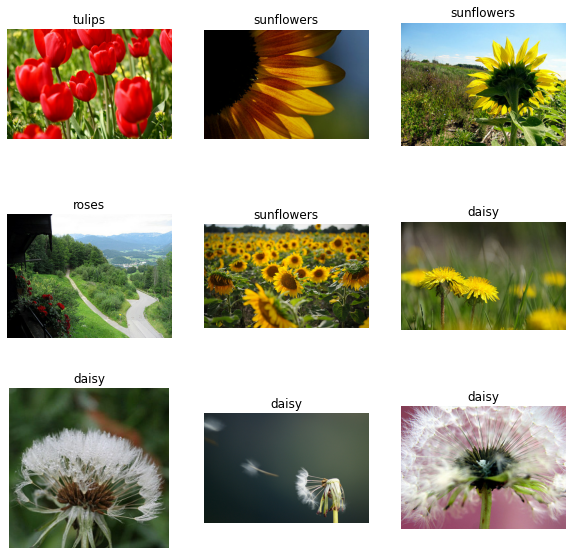

In [ ]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(classes[int(label)])
  plt.axis("off")

In [ ]:
# Image resize
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
# Normalization utils
def normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

In [ ]:
# Construct the batched dataset
batch_size = 32
AUTO = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(normalize_img, num_parallel_calls=AUTO).\
    shuffle(1024).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Modelling Phase

In [ ]:
# Load the MobileNetV2 model but exclude the classification layer
base_model = MobileNetV2(weights = 'imagenet',include_top = False,input_shape=(dim,dim,3))
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [ ]:
def get_training_model(trainable=False):

    # Freeze the base model 
    base_model.trainable = trainable
   
    # Add Global Average layer 
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add custom layers
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation="softmax")(x)

    # Create the new model
    model = keras.models.Model(inputs=base_model.input, outputs=x)

    # Compile and return the model
    model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer="adam",
                          metrics=["accuracy"])

    return model

In [ ]:
flower_model = get_training_model(trainable=False)
flower_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
# Model training
history = flower_model.fit(train_ds,
              validation_data=validation_ds,
              epochs=10,
              callbacks=[early_stop],verbose=1)


Epoch 1/10
98/98 [==============================] - 8s 57ms/step - loss: 0.6322 - accuracy: 0.7744 - val_loss: 0.3184 - val_accuracy: 0.8891
Epoch 2/10
98/98 [==============================] - 5s 50ms/step - loss: 0.3434 - accuracy: 0.8808 - val_loss: 0.3266 - val_accuracy: 0.8727
Epoch 3/10
98/98 [==============================] - 5s 50ms/step - loss: 0.2635 - accuracy: 0.9038 - val_loss: 0.2729 - val_accuracy: 0.9018
Epoch 4/10
98/98 [==============================] - 6s 50ms/step - loss: 0.1972 - accuracy: 0.9298 - val_loss: 0.2858 - val_accuracy: 0.9055
Epoch 5/10
98/98 [==============================] - 5s 50ms/step - loss: 0.1711 - accuracy: 0.9378 - val_loss: 0.2506 - val_accuracy: 0.9200
Epoch 6/10
98/98 [==============================] - 6s 56ms/step - loss: 0.1255 - accuracy: 0.9577 - val_loss: 0.2571 - val_accuracy: 0.9127
Epoch 7/10
98/98 [==============================] - 5s 50ms/step - loss: 0.1029 - accuracy: 0.9641 - val_loss: 0.2929 - val_accuracy: 0.9127
Epoch 8/10
98

# Step2 : Model Evaluation and Saving

In [ ]:
## Model Evaluation 
test_loss, test_accuracy = flower_model.evaluate(validation_ds)
print("Testing Accuracy : {} Testing Loss : {}".format(test_accuracy,test_loss))

18/18 [==============================] - 1s 37ms/step - loss: 0.3051 - accuracy: 0.9218
Testing Accuracy : 0.921818196773529 Testing Loss : 0.30508241057395935


In [ ]:
# save the model 
model.save('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model.h5')
!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model.h5

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


-rw------- 1 root root 17M Jul  3 09:49 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model.h5


# Step3 : Model Conversion to TFlite

In [ ]:
# Load the model 
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model.h5')
model.summary()

In [ ]:
# Convert the keras model to Tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the tflite model.
with open('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower.tflite', 'wb') as f:
    f.write(tflite_model)

!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower.tflite

-rw------- 1 root root 11M Jul  3 10:04 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower.tflite


# Step4 : TFlite Model evaluation using TFlite Interpreter

In [ ]:
# A helper function to evaluate the TF Lite model using "validation" dataset.
# Referred from: https://www.tensorflow.org/lite/performance/post_training_integer_quant
def evaluate_model(interpreter):
    accurate_count = 0

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    input_details = interpreter.get_input_details()[0]

    # Run predictions on every image in the "test" dataset.
    predictions = []
    for (val_images, val_labels) in validation_ds:
        for val_image, val_label in zip(val_images, val_labels):

            if input_details['dtype'] == np.uint8:
                input_scale, input_zero_point = input_details["quantization"]
                val_image = val_image / input_scale + input_zero_point

            #val_image = tf.expand_dims(val_image, 0).astype(input_details["dtype"])
            val_image = np.expand_dims(val_image, axis=0).astype(input_details["dtype"])
            interpreter.set_tensor(input_details["index"], val_image)

            # Run inference.
            interpreter.invoke()

            # Post-processing: remove batch dimension and find the digit with highest
            # probability.
            probability = interpreter.get_tensor(output_index)
            flower_id = np.argmax(probability[0])
            predictions.append(flower_id)

            # Compare prediction results with ground truth labels to calculate accuracy.
            if flower_id == val_label:
                accurate_count += 1

            accuracy = accurate_count * 1.0 / len(predictions)

    return accuracy

In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower.tflite')
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.9054545454545454


# Model Optimization Toolkit

## Quantization 

1.   Post-Training Quantization 
2.   During Traing Quantization 



### Post-Training Quantization 

#### 1) Post-training dynamic range quantization

Dynamic range quantization achieves a 4x reduction in the model size.


In [ ]:
# Convert the keras model to Tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpwxus2bw0/assets


INFO:tensorflow:Assets written to: /tmp/tmpwxus2bw0/assets


OPTIMIZE_FOR_SIZE Deprecated. Does the same as DEFAULT.

OPTIMIZE_FOR_LATENCY Deprecated. Does the same as DEFAULT.

EXPERIMENTAL_SPARSITY Experimental flag, subject to change.

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_drq = converter.convert()

# Save the tflite model.
with open('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite', 'wb') as f:
    f.write(tflite_model_drq)

!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpkantqati/assets


INFO:tensorflow:Assets written to: /tmp/tmpkantqati/assets


-rw------- 1 root root 3.2M Jul  3 10:45 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite


##### Evaluate the dynamic range quant tflite

In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite')
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.8945454545454545


#### 2) Post-training integer quantization

Integer quantization is an optimization strategy that converts 32-bit floating-point numbers (such as weights and activation outputs) to the nearest 8-bit fixed-point numbers. This results in a smaller model and increased inferencing speed, which is valuable for low-power devices such as microcontrollers. 

In [ ]:
def representative_data_gen():
  #for input_value in tf.data.Dataset.from_tensor_slices(validation_ds).batch(1).take(100):
  for i,(image, label) in enumerate(train_ds.take(100)):
    print(i)
    yield [image]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [ ]:
tflite_model_quant = converter.convert()

In [ ]:
# Save the tflite model.
with open('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_integer_quant_pq.tflite', 'wb') as f:
    f.write(tflite_model_quant)


!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_integer_quant_pq.tflite

-rw------- 1 root root 3.3M Jul  3 11:09 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_integer_quant_pq.tflite


In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_integer_quant_pq.tflite')
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.9072727272727272


#### 3) Post-training float16 quantization

In [ ]:
# Convert the keras model to Tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_fp16_quant_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpdnhcd09k/assets


INFO:tensorflow:Assets written to: /tmp/tmpdnhcd09k/assets


In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [ ]:
# Save the tflite model.
with open('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_float16_quant_pq.tflite', 'wb') as f:
    f.write(tflite_model_drq)

!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite

-rw------- 1 root root 3.2M Jul  3 10:45 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_dynamic_range_pq.tflite


### Quantization Aware Training

In [ ]:
# Import `tfmot` library
#!pip install -q tensorflow-model-optimization

import tensorflow_model_optimization as tfmot

In [ ]:
# Allow the model to be trained in a quantization-aware manner
flower_model = get_training_model(trainable=True)
q_flower_model = tfmot.quantization.keras.quantize_model(flower_model)
q_flower_model.summary()

In [ ]:
# Compile the model 
q_flower_model.compile(loss="sparse_categorical_crossentropy", 
                          optimizer=tf.keras.optimizers.Adam(1e-5),
                          metrics=["accuracy"])

In [ ]:
history = q_flower_model.fit(train_ds,
              validation_data=validation_ds,
              epochs=15,
              callbacks=[early_stop],verbose=1)

Epoch 1/15
98/98 [==============================] - 44s 438ms/step - loss: 0.2690 - accuracy: 0.9096 - val_loss: 0.3316 - val_accuracy: 0.8800
Epoch 2/15
98/98 [==============================] - 44s 439ms/step - loss: 0.2208 - accuracy: 0.9269 - val_loss: 0.3072 - val_accuracy: 0.8873
Epoch 3/15
98/98 [==============================] - 44s 440ms/step - loss: 0.2123 - accuracy: 0.9276 - val_loss: 0.2859 - val_accuracy: 0.8964
Epoch 4/15
98/98 [==============================] - 44s 439ms/step - loss: 0.1959 - accuracy: 0.9346 - val_loss: 0.2757 - val_accuracy: 0.8945
Epoch 5/15
98/98 [==============================] - 44s 438ms/step - loss: 0.1711 - accuracy: 0.9458 - val_loss: 0.2621 - val_accuracy: 0.9000
Epoch 6/15
98/98 [==============================] - 44s 442ms/step - loss: 0.1499 - accuracy: 0.9538 - val_loss: 0.2438 - val_accuracy: 0.9055
Epoch 7/15
98/98 [==============================] - 44s 439ms/step - loss: 0.1385 - accuracy: 0.9561 - val_loss: 0.2311 - val_accuracy: 0.9109

In [ ]:
## Model Evaluation 
test_loss, test_accuracy = q_flower_model.evaluate(validation_ds)
print("Testing Accuracy : {} Testing Loss : {}".format(test_accuracy,test_loss))

18/18 [==============================] - 2s 106ms/step - loss: 0.1859 - accuracy: 0.9327
Testing Accuracy : 0.9327272772789001 Testing Loss : 0.18589960038661957


In [ ]:
# save the model 
model.save('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model_QAT.h5')
!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model_QAT.h5

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


-rw------- 1 root root 17M Jul  3 12:45 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_model_QAT.h5


#### Convert the QAT keras model to tflite 

In [ ]:
# Quantize `q_flower_model` (this one was trained with QAT)
converter = tf.lite.TFLiteConverter.from_keras_model(q_flower_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [ ]:
tflite_QAT_model = converter.convert()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tmp/tmpume6f522/assets


INFO:tensorflow:Assets written to: /tmp/tmpume6f522/assets


In [ ]:
# Save the tflite model.
with open('/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_QAT.tflite', 'wb') as f:
    f.write(tflite_QAT_model)


!ls -lh /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_QAT.tflite

-rw------- 1 root root 3.3M Jul  3 12:45 /content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_QAT.tflite


In [ ]:
# Load the model into interpreters
interpreter_qat = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Colab_Notebooks/SJCEM_TFlite_Session/flower_QAT.tflite')
interpreter_qat.allocate_tensors()

# Evaluate the performance
print(evaluate_model(interpreter_qat))

0.8745454545454545


## Model Pruning 